In this notebook we use the model found to predict new points

In [1]:
import sys
sys.path.append("..")
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import scipy.integrate as integrate
import scipy.optimize as optimize
import math

In [2]:
name="N40_t40_Tr3_s2322_x20.0_lscale5"
model=torch.load('Graph_and_modelsave/GPSDE_model_'+name+'.pt')
with open("Graph_and_modelsave/GPSDE_inference_"+name+".pkl",'rb') as file:
    inference=pickle.load(file)

## Dynamics

d:\logiciel\miniconda\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\fosmo\OneDrive\Documents\GitHub\gpsde\demos\..\transition.py:405: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:766.)
  Ak, _ = torch.solve(q_mu, Kzz)


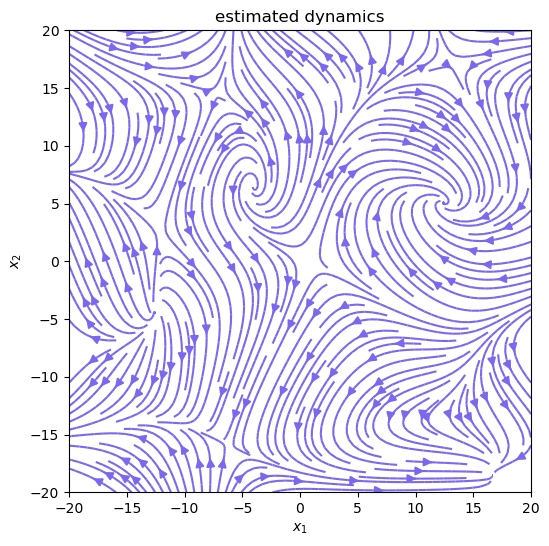

In [3]:
ngrid = 200
xmin = -20#modify
xmax = 20
x = torch.linspace(xmin,xmax,ngrid)
y = torch.linspace(xmin,xmax,ngrid)

xv, yv = torch.meshgrid([x, y])
xygrid = torch.cat((yv.reshape(-1, 1),xv.reshape(-1, 1)),dim=1)
out_est = model.transfunc.predict(xygrid.unsqueeze(0))
# visualise dynamics
sz = 6
plt.figure(figsize=(sz,sz))

plt.streamplot(x.numpy(), y.numpy(), out_est[0,:,0].detach().reshape(ngrid,ngrid).numpy(), 
           out_est[0,:,1].detach().numpy().reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='mediumslateblue')

        
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('estimated dynamics')
plt.axis('square')
plt.show()

In [17]:
out_est.shape

torch.Size([1, 40000, 2])

## Use the model to create new data

First, we need to get the solution of the SDE :
$$dx=f(x)dt+\sqrt(\Sigma)dw \\ E_{y|x}[y(t_i)]=g(Cx(t_i)+d), i=1,...,T$$
We do it using two different methods : the scipy function and the Euler scheme.

In the paper, they solve instead :
$$dx=(-A(t)x(t)+b(t))dt+\sqrt(\Sigma)dw $$
where A and b are found using eq 19-22 that use the Sparse GP process

Every function seems to predict the mean at point t of the result
- m,S=model.inference.predict_marginals( idx, t) => predict m the mean of the marginal, S the variance at time t , trial idx for a grid of points using A and b
- mean=model.transfunc.predict(x) => predict conditional mean of sparse GP at new input locations x of the form R x N x K 
- mean=model.transfunc.f(m, S)=>predict expected conditional mean of sparse GP

The time is no explicit in the gp as m,S and x depends on time , R=#trials, N=neurons, K=latent dim

### Scipy

In [46]:
def f_ode(t,x):
    gp_f=model.transfunc.predict(torch.Tensor(x))
    return (gp_f.squeeze())

print(f_ode(0,[1,1]))

tensor([0.0818, 0.1482], dtype=torch.float64, grad_fn=<SqueezeBackward0>)


In [28]:
with torch.no_grad():
    sol=integrate.solve_ivp(f_ode,(0.,40.),torch.Tensor([18,2]))

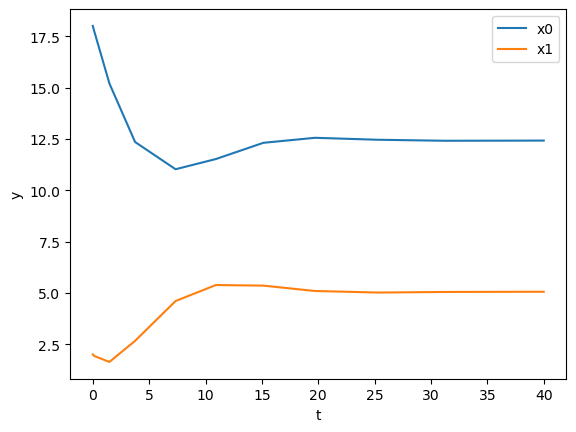

In [29]:
plt.plot(sol.t,sol.y[0],label="x0")
plt.plot(sol.t,sol.y[1],label="x1")
plt.xlabel("t")
plt.ylabel('y')
plt.legend()
plt.show()

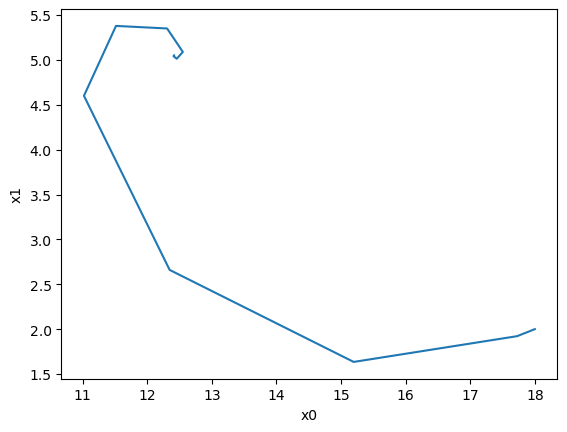

In [30]:
plt.plot(sol.y[0],sol.y[1])
plt.xlabel('x0')
plt.ylabel("x1")
plt.show()


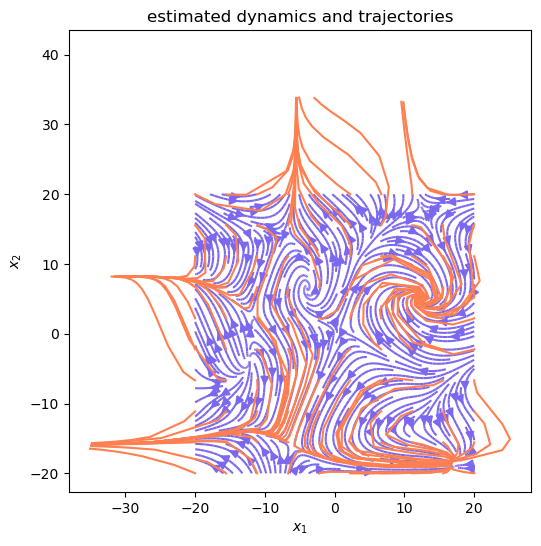

In [16]:
# Superpose the trajectories and the dynamics:

ngrid = 10
xmin = -20
xmax = 20
x = torch.linspace(xmin,xmax,ngrid)
y = torch.linspace(xmin,xmax,ngrid)

xv, yv = torch.meshgrid([x, y])
xygrid = torch.cat((yv.reshape(-1, 1),xv.reshape(-1, 1)),dim=1)
out_est = model.transfunc.predict(xygrid.unsqueeze(0)) #compute the dyamics on the grid
# visualise dynamics
sz = 6
plt.figure(figsize=(sz,sz))
plt.streamplot(x.numpy(), y.numpy(), out_est[0,:,0].detach().reshape(ngrid,ngrid).numpy(), 
           out_est[0,:,1].detach().numpy().reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='mediumslateblue')

for x0_ini in x.numpy():
       for x1_ini in y.numpy():
              with torch.no_grad():
                     sol=integrate.solve_ivp(f_ode,(0.,120.),torch.Tensor([x0_ini,x1_ini]))
              plt.plot(sol.y[0],sol.y[1],color='coral')
    
        
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('estimated dynamics and trajectories')
plt.axis('square')
plt.savefig("Generation/dynamics&trajectories_"+name+".pdf")
plt.show()

### Using Euler Forward method
Without noise, we get the same plot for the two methods so it should be equivalent, but the scipy is much faster. We add gaussian noise to this one.
The noise create strange results.

In [47]:
def Euler_Forward(f,tmax,y0,dt,noise=False,sigma=1.):
    "f the function in dy/dt=f(t,y), tmax the maximum time, y0 initial condition and dt the interval between two times"
    t=[0]
    y=[y0]
    for i in range(1,math.floor(tmax/dt)):
        if noise:
            new_y=y[i-1]+dt*np.array(f(t[i-1],y[i-1])) + np.sqrt(sigma * dt) * np.random.randn(y0.shape[0])
        else:
            new_y=y[i-1]+dt*np.array(f(t[i-1],y[i-1]))
        y.append(new_y)
        t.append(i*dt)
    return t,y

In [33]:
with torch.no_grad():
    t,y=Euler_Forward(f_ode,40,np.array([18,2]),0.01,noise=True,sigma=1.)

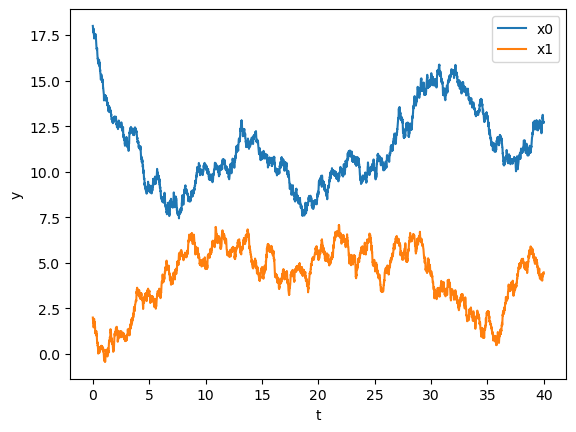

In [34]:
y=np.array(y) #this plot can some time be vary bad
y=y.T
plt.plot(t,y[0],label="x0")
plt.plot(t,y[1],label="x1")
plt.xlabel("t")
plt.ylabel('y')
plt.legend()
plt.show()

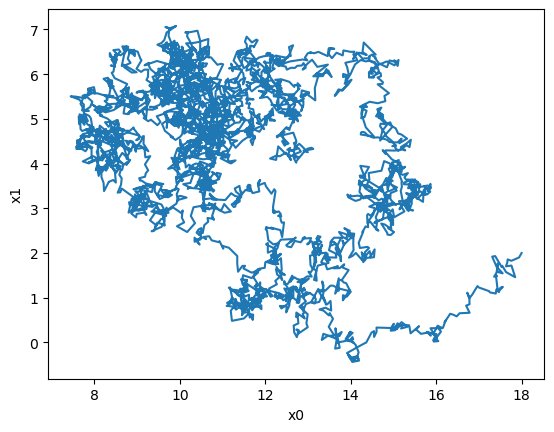

In [35]:
plt.plot(y[0],y[1])
plt.xlabel('x0')
plt.ylabel("x1")
plt.show()

C:\Users\fosmo\AppData\Local\Temp\ipykernel_27912\343869451.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t,y=Euler_Forward(f_ode,40,np.array([x0_ini,x1_ini]),0.01,noise=True,sigma=1.)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

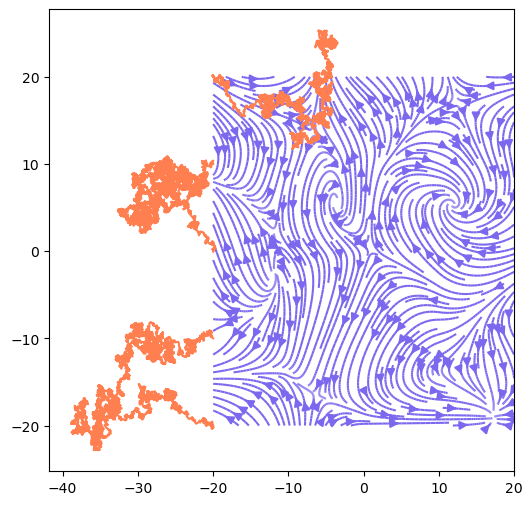

In [37]:
# Superpose the trajectories and the dynamics:

ngrid = 5
xmin = -20
xmax = 20
x = torch.linspace(xmin,xmax,ngrid)
y = torch.linspace(xmin,xmax,ngrid)

xv, yv = torch.meshgrid([x, y])
xygrid = torch.cat((yv.reshape(-1, 1),xv.reshape(-1, 1)),dim=1)
out_est = model.transfunc.predict(xygrid.unsqueeze(0)) #compute the dyamics on the grid
# visualise dynamics
sz = 6
plt.figure(figsize=(sz,sz))
plt.streamplot(x.numpy(), y.numpy(), out_est[0,:,0].detach().reshape(ngrid,ngrid).numpy(), 
           out_est[0,:,1].detach().numpy().reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='mediumslateblue')

for x0_ini in x:
       for x1_ini in y:
              with torch.no_grad():
                     t,y=Euler_Forward(f_ode,40,np.array([x0_ini,x1_ini]),0.01,noise=True,sigma=1.)
              y=np.array(y)
              y=y.T
              plt.plot(y[0],y[1],color='coral')
    
        
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('estimated dynamics and trajectories')
plt.axis('square')
plt.savefig("Generation/dynamics&trajectories_noisy_"+name+".pdf")
plt.show()

## Generate spikes from the model

In [51]:
#Create spike from sde for neural pop dynamic 5.3 
def simulate_spikes_from_SDE(xpath, dt, C, d):
    """Input :  xpath (tmax/dt,2) array from simulate_sde
                dt float
                C (2,Num_Neurons) array
                d (1,Num_Neurons) array
       Output : binspike (tmax/dt,Num_Neurons) array for each time i neuron n draw a poisson rv with lambda=exp(h[i,n]dt)
                h (tmax/dt,Num_Neurons) intensity function (log(lambda) )"""
    # simulate Poisson spiking conditioned on discretised path of SDE
    h = np.matmul(xpath,C) + d # intensity function
    binSpike=np.array([])
    #binSpike = np.random.poisson(np.exp(h+np.log(dt))) #expected number of spike in time bin dt
    return binSpike, h

#Conversion function to a list of time for eacch neuron
def binned_to_times(Ybin, tmax, dt):
    """Input :  Ybin (Num_Neurons, tmax/dt) correspond to binspike transpose !!
                tmax float
                dt float
        Ouput : list of two arrays : array i contain time at which neuron i was >0 in Ybin"""
    # convert binned simulated spike train to list of spike times for each neuron
    N = int(tmax / dt)
    yDim = Ybin.shape[0]
    tgrid = np.linspace(dt, tmax, N)
    Yspike = []
    for i in range(yDim):
        Yspike.append(tgrid[Ybin[i, :] > 0] + 1e-6 * np.random.randn(*np.shape(tgrid[Ybin[i, :] > 0]))) #noise too avoid 2 event at exactly the same time point

    return Yspike


We first do it for one possible x0 

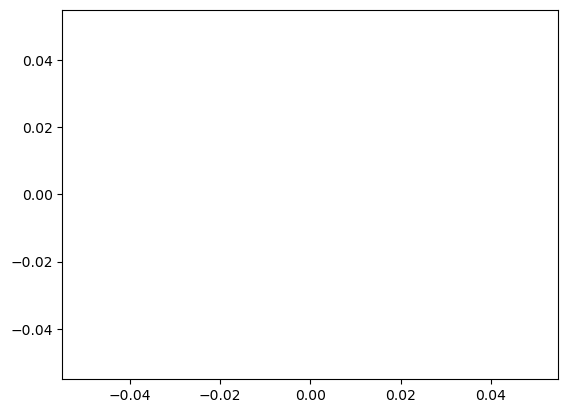

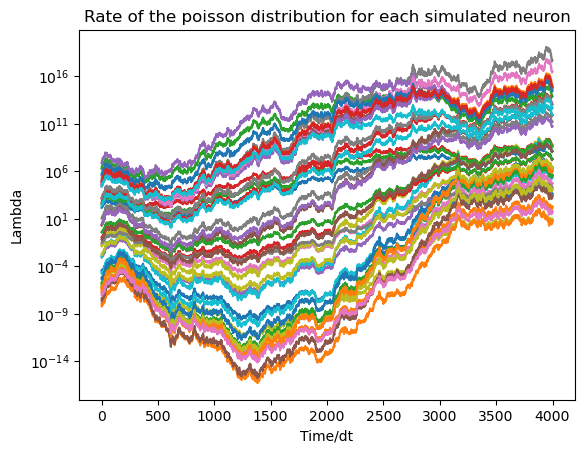

Number of spikes


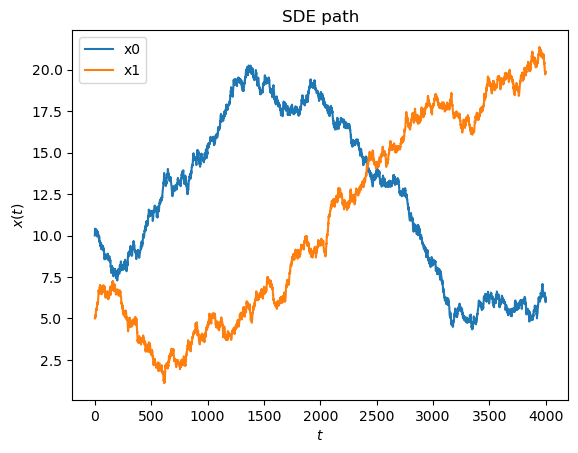

In [68]:
np.random.seed(101) 

#Parameters & initialisations
yDim = 40 # number of neurons
xDim = 2 #xpath dim
tmax = 40
with torch.no_grad():
    C = np.array(model.outputMapping.Subspace)
    d = np.array(model.outputMapping.Offset)
dt=0.01

#Generate sde path and spike for every trials
#For every trial randomness in x0, poisson, random in sde

x0 = np.array([10,5])

with torch.no_grad():
    t,y=Euler_Forward(f_ode,tmax,x0,dt,noise=True,sigma=1)
    
    y=np.array(y)
    Yn,logRaten = simulate_spikes_from_SDE(y, dt, C, d) #generate spikes for this trial

#Yspike List by trial of a list by Neuron of array of spike time
#Yspike[i]=>List of Neuron for trial i, Yspike[i][j]=>Array of spike time for neuron j in trial i
Yspike= binned_to_times(Yn.T,tmax,dt) 

#plots and prints 
ids=[]
times=[]
i=0
for neuron in Yspike:
    for t in neuron:
        ids.append(i)
        times.append(t)
    i+=1

plt.scatter(times,ids,marker='|')
plt.show()

# look at firing rates and spike counts to make sure there aren't a crazy number of spikes due to exponential
plt.semilogy(np.exp(logRaten)*dt,label='Trial ') # correspond to the lambda of the poisson function for each neuron
plt.xlabel('Time/dt')
plt.ylabel('Lambda')
plt.title('Rate of the poisson distribution for each simulated neuron')
plt.savefig('Rate_simulated.pdf')
plt.show()

print("Number of spikes")

#totSpikes = [len(Yspike[i]) for i in range(yDim)]
#print("min : "+str(min(totSpikes))+" max : "+str(max(totSpikes)))

#plt.plot(xpath[1])
plt.plot(y[:,0],label='x0')
plt.plot(y[:,1],label='x1')
plt.legend()
plt.title('SDE path')
plt.ylabel('$x(t)$')
plt.xlabel('$t$')
plt.show()

For differents x0:

[-2  6]
[0 4]
[2.5 2.5]
[0 0]


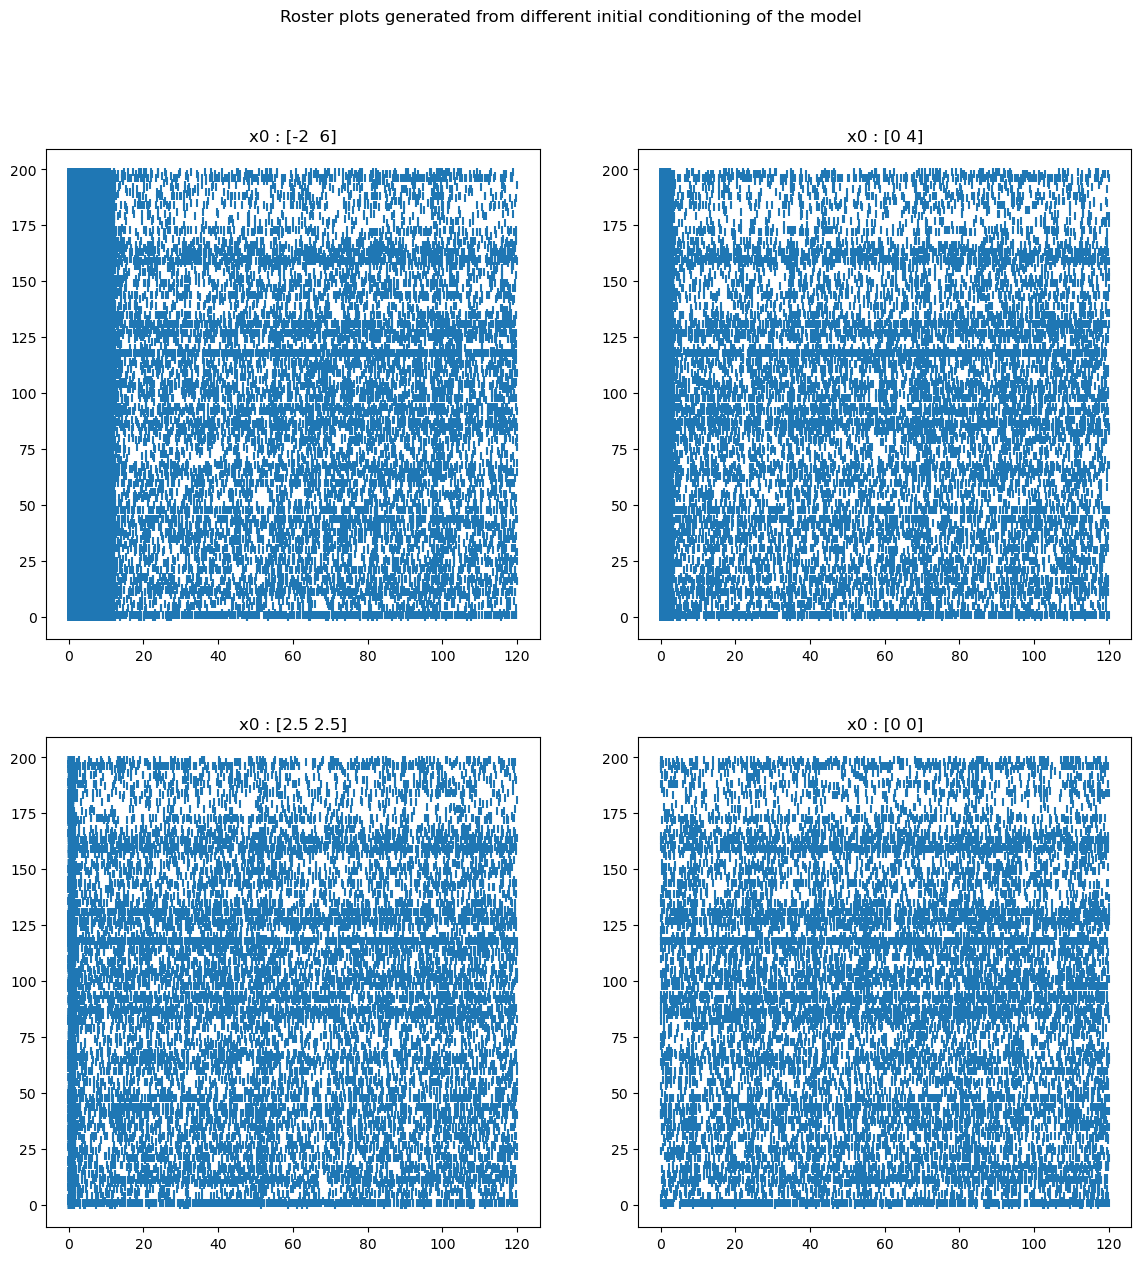

In [42]:
np.random.seed(28) 

#Parameters & initialisations
yDim = 200 # number of neurons
xDim = 2 #xpath dim
tmax = 120
with torch.no_grad():
    C = np.array(model.outputMapping.Subspace)
    d = np.array(model.outputMapping.Offset)
dt=0.004

X0=[[-2,6],[0,4],[2.5,2.5],[0,0]] #less than -3 don't work for x2

f,ax=plt.subplots(2,2,figsize=(14,14))

for j in range(len(X0)):
    #Generate sde path and spike for every trials
    #For every trial randomness in x0, poisson, random in sde
    ax1=j//2
    ax2=j%2

    x0=np.array(X0[j])
    print(x0)
    
    with torch.no_grad():
        t,y=Euler_Forward(f_ode,tmax,x0,dt,noise=True,sigma=0.1)
        y=np.array(y)
        Yn,logRaten = simulate_spikes_from_SDE(y, dt, C, d) #generate spikes for this trial

    #Yspike List by trial of a list by Neuron of array of spike time
    #Yspike[i]=>List of Neuron for trial i, Yspike[i][j]=>Array of spike time for neuron j in trial i
    Yspike= binned_to_times(Yn.T,tmax,dt) 

    #plots and prints 
    ids=[]
    times=[]
    i=0
    for neuron in Yspike:
        for t in neuron:
            ids.append(i)
            times.append(t)
        i+=1
    ax[ax1,ax2].scatter(times,ids,marker='|')
    ax[ax1,ax2].set_title('x0 : '+str(x0))
plt.suptitle("Roster plots generated from different initial conditioning of the model")
plt.savefig("Generation/generation_28_"+name+".pdf")
plt.show()

## Fixed points

In [23]:
with torch.no_grad():
    fixed=optimize.fsolve(lambda x:f_ode(0,x),np.array([0,1]))

c:\Users\fosmo\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [26]:
print(fixed)

[49.97350152 -0.62761973]


d:\logiciel\miniconda\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


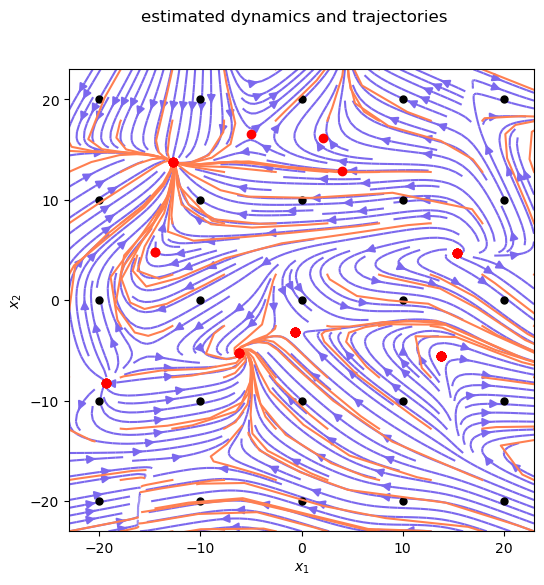

In [69]:
# Superpose the trajectories, the dynamics and the fixed points (without noise to be faster, replace the function for noise):


# visualise dynamics
ngrid=200
xmin = -23
xmax = 23
x = torch.linspace(xmin,xmax,ngrid)
y = torch.linspace(xmin,xmax,ngrid)

xv, yv = torch.meshgrid([x, y])
xygrid = torch.cat((yv.reshape(-1, 1),xv.reshape(-1, 1)),dim=1)
out_est = model.transfunc.predict(xygrid.unsqueeze(0)) #compute the dyamics on the grid

sz = 6
#dynamics
plt.figure(figsize=(sz,sz))
plt.streamplot(x.numpy(), y.numpy(), out_est[0,:,0].detach().reshape(ngrid,ngrid).numpy(), 
           out_est[0,:,1].detach().numpy().reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='mediumslateblue')

#inducing point
plt.plot(model.transfunc.Zs.detach().numpy()[:,0,], model.transfunc.Zs.detach().numpy()[:,1], 'o', color='black', markersize=5)

#trajectories generated
x_traj=torch.linspace(xmin,xmax,10)
y_traj=torch.linspace(xmin,xmax,10)
for x0_ini in x_traj:
       for x1_ini in y_traj:
              with torch.no_grad():
                     sol=integrate.solve_ivp(f_ode,(0.,40.),torch.Tensor([x0_ini,x1_ini]))
              plt.plot(sol.y[0],sol.y[1],color='coral')

#latent plot
#testTimes = torch.linspace(0,40,int(40/0.01))
#m, S = inference.predict_marginals(0, testTimes)
#mr, Sr, Corth = model.outputMapping.orthogonaliseLatents(m,S)
#plt.plot(mr[:,0,0].detach().squeeze().numpy(),mr[:,0,1].detach().squeeze().numpy(),color='green')



#fixed points
allfixed=[]
for i in np.linspace(-25,25,40):
       for j in np.linspace(-15,15,40):
              with torch.no_grad():
                     fixed=optimize.fsolve(lambda x:f_ode(0,x),np.array([i,j]))
                     allfixed.append(fixed)
              plt.plot(fixed[0],fixed[1],color='r',marker='o')
#allfixed=np.array(allfixed)
#print(np.unique(allfixed))

plt.xlim([-23,23])
plt.ylim([-23,23])   

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.suptitle('estimated dynamics and trajectories')
#plt.axis('square')
plt.savefig("Generation/dynamics&trajectories&fixed_interpolationout20"+name+".pdf")
plt.show()

## Latent

In [88]:

testTimes = torch.linspace(0,40,int(40/0.01))

m, S = inference.predict_marginals(0, testTimes)
mr, Sr, Corth = model.outputMapping.orthogonaliseLatents(m,S)

In [89]:
mr[0,0,:].detach().numpy()

array([18.16516545,  1.60049892])

In [100]:
with torch.no_grad():
    t,y=Euler_Forward(f_ode,40,mr[0,0,:].detach().numpy(),0.01,noise=True,sigma=1.)

y=np.array(y)
y=y.T
print(len(t))
print(y.shape)

4000
(2, 4000)


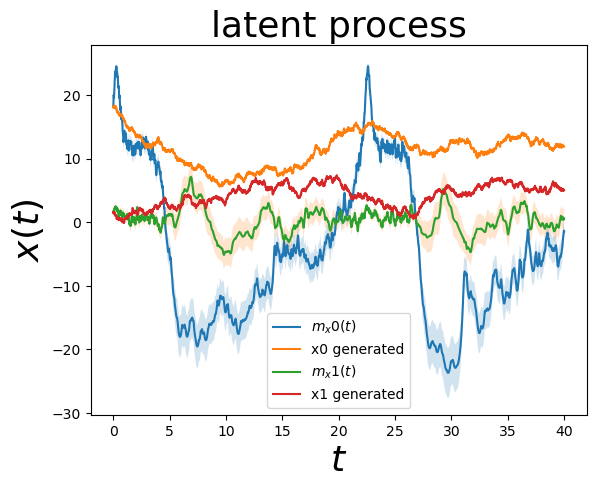

In [101]:

plt.plot(testTimes.numpy(),mr[:,0,0].detach().squeeze().numpy(), label='$m_x0(t)$')
plt.fill_between(testTimes.numpy(), mr[:,0,0].detach().numpy()+np.sqrt(Sr[:,0,0].detach().numpy()), 
            mr[:,0,0].detach().squeeze().numpy()-np.sqrt(Sr[:,0,0].detach().numpy()), alpha=0.2)
plt.plot(t,y[0],label="x0 generated")

plt.plot(testTimes.numpy(),mr[:,0,1].detach().squeeze().numpy(), label='$m_x1(t)$')
plt.fill_between(testTimes.numpy(), mr[:,0,1].detach().numpy()+np.sqrt(Sr[:,1,1].detach().numpy()), 
            mr[:,0,1].detach().squeeze().numpy()-np.sqrt(Sr[:,1,1].detach().numpy()), alpha=0.2)
plt.plot(t,y[1],label="x1 generated")

plt.ylabel('$x(t)$',fontsize=26)
plt.xlabel('$t$',fontsize=26)
plt.title('latent process',fontsize=26)
plt.legend()
plt.savefig('Latent'+name+".pdf")
plt.show()